## Enviroment

In [1]:
!nvidia-smi

Sat Apr  9 06:51:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Download Dataset

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown --id '1e4PNQoeQCR2TTvqaHL1-Aiyi76pIOFAY' --output image_data.zip
!unzip './image_data.zip'

## Import Packages

In [4]:
from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import numpy as np

## Training Dataset

In [5]:
train_path = './image_data/train/'
classes = ["daisy", "dandelion", "rose", "sunflower", "tulip"]

imsize = (224, 224)
num_classes = 5

train_imgs = []
targets = []

for i, c in enumerate(classes):
    files_path = os.listdir(train_path + c)
    for f in files_path:
        img = cv2.imread(train_path + c + '/' + f)
        img = cv2.resize(img, imsize)
        img = img[:, :, [2,1,0]]
        
        train_imgs.append(img)
        targets.append(i)

train_imgs = np.array(train_imgs, dtype=np.float32)
targets = np.array(targets, dtype=np.int64)

X_train, X_val, y_train, y_val = train_test_split(train_imgs, 
                                                  targets, 
                                                  test_size=0.1,
                                                  random_state=1)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

print(f'X_train shape: {X_train.shape}')
print(f'{X_train.shape[0]} train samples')
print(f'{X_val.shape[0]} test samples')

X_train shape: (2540, 224, 224, 3)
2540 train samples
283 test samples


In [6]:
batch_size = 64

train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   rescale=1./255,
                                   dtype="float32")

test_datagen = ImageDataGenerator(rescale=1./255, 
                                  dtype="float32")

train_generator = train_datagen.flow(X_train, y_train, 
                                     batch_size=batch_size, 
                                     shuffle=True)

valid_generator = test_datagen.flow(X_val, y_val, 
                                    batch_size=batch_size,
                                    shuffle=False)

## Model

In [7]:
net = ResNet50V2(include_top=False, 
                 weights='imagenet', 
                 input_tensor=None,
                 input_shape=(imsize[0], imsize[1], 3), 
                 pooling="avg",
                 classes=num_classes)
x = net.output

x = Flatten()(x)

output_layer = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=net.input, outputs=output_layer)

model.summary()

94683136/94668760 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

## Train

In [8]:
epochs = 50

lr = 1e-3

lr_reducer = ReduceLROnPlateau(factor=0.1, 
                               min_lr=1e-8,
                               monitor='val_loss',
                               patience=5,
                               verbose=1)

callbacks = [lr_reducer]

In [9]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr),
              metrics=['accuracy'])

history = model.fit(train_generator,
                    epochs=epochs,
                    verbose=1,
                    validation_data=valid_generator, 
                    callbacks=callbacks)

Epoch 1/50
40/40 [==============================] - 45s 765ms/step - loss: 0.8626 - accuracy: 0.7000 - val_loss: 8.9622 - val_accuracy: 0.2898 - lr: 0.0010
Epoch 2/50
40/40 [==============================] - 31s 769ms/step - loss: 0.6330 - accuracy: 0.7681 - val_loss: 49.3970 - val_accuracy: 0.2120 - lr: 0.0010
Epoch 3/50
40/40 [==============================] - 30s 746ms/step - loss: 0.5252 - accuracy: 0.8106 - val_loss: 8.2449 - val_accuracy: 0.4452 - lr: 0.0010
Epoch 4/50
40/40 [==============================] - 30s 742ms/step - loss: 0.4585 - accuracy: 0.8346 - val_loss: 4.2465 - val_accuracy: 0.6537 - lr: 0.0010
Epoch 5/50
40/40 [==============================] - 30s 743ms/step - loss: 0.3893 - accuracy: 0.8539 - val_loss: 2.0121 - val_accuracy: 0.6714 - lr: 0.0010
Epoch 6/50
40/40 [==============================] - 30s 744ms/step - loss: 0.3936 - accuracy: 0.8646 - val_loss: 1.0525 - val_accuracy: 0.7032 - lr: 0.0010
Epoch 7/50
40/40 [==============================] - 30s 744ms/s

## Plot Learning Curves

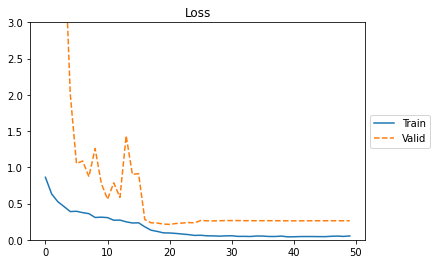

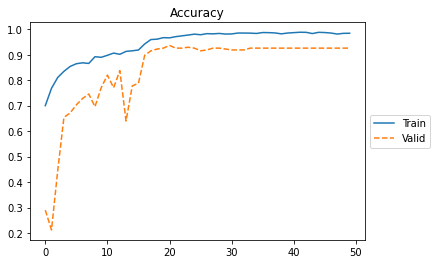

In [10]:
plt.figure()

plt.plot(range(len(history.history['loss'])), 
         history.history['loss'], 
         '-', label="Train")

plt.plot(range(len(history.history['val_loss'])),
         history.history['val_loss'], 
         '--', label="Valid")

plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim([0, 3])
plt.show()

plt.figure()

plt.plot(range(len(history.history['accuracy'])), 
         history.history['accuracy'], 
         '-', label="Train")

plt.plot(range(len(history.history['val_accuracy'])),
         history.history['val_accuracy'], 
         '--', label="Valid")
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Predict

In [11]:
test_path = './image_data/test'
files_path = os.listdir(test_path)

test_imgs = []

for f in files_path:
    img = cv2.imread(test_path + '/' + f)
    img = cv2.resize(img, imsize)
    img = img[:, :, [2,1,0]]
    
    test_imgs.append(img)
    
test_imgs = np.array(test_imgs, dtype=np.float32)

test_imgs /= 255.

print(f'test_imgs shape: {test_imgs.shape}')

test_imgs shape: (2000, 224, 224, 3)


In [12]:
prediction = model.predict(test_imgs, batch_size=batch_size)
prediction = np.argmax(prediction, axis=1)

In [13]:
pred_file = "./prediction.csv"

with open(pred_file, "w") as f:
    f.write("id,flower_class\n")
    for i, pred in enumerate(prediction):
        f.write(f"{files_path[i][:-4]},{pred}\n")